 ### 코드 구현 계획

1. 데이터 로드
무엇을: pd.read_csv()로 원본 CSV를 DataFrame에 읽어온다.

2. 특성 분류
무엇을:
numeric_features 목록에 수치형 입력 컬럼만 담는다.
categorical_features 목록에 범주형 입력 컬럼만 담는다.
왜:
전처리 단계에서 인코딩해야 하는 특성을 분류하기 위함

3. 학습용 데이터 분리
무엇을: avg_salary가 결측이 아닌 행만 사용한다.
왜: 타깃이 없는 행은 모델을 학습할 수 없으므로 별도로 보존해기 위함(최종적으로 타깃 결측치는 가장 성능이 좋은 모델을 활용하여 채울 예정)

4. 전처리 
무엇을: 
수치형- 평균값으로 대체
범주형- 최빈값 대체 후 One-Hot 인코딩
왜: 결측치를 처리하고, 범주형을 수치로 변환해 모델 학습을 위해서

5. 모델 파이프라인 구축
무엇을: 동일한 preprocessor 후에
1)LinearRegression, 2) RandomForestRegressor, 3) GradientBoostingRegressor를 각각 연결한다.
왜: 선형과 비선형 모델의 성능을 비교하려는 목적

6. 교차검증 설정 & 평가 함수
무엇을: RepeatedKFold와 cross_validate을 활용하는 평가 함수를 작성한다.
왜: 데이터 재표본화를 통해 일반화 성능(R², RMSE, MAE)을 안정적으로 추정하기 위해서

7. 모델 성능 비교 테이블 출력
무엇을: 세 모델의 평가 결과를 DataFrame 으로 정렬·표시한다.
왜: 지표별 우수 모델을 한눈에 확인하고, 최종 모델을 선택하기 위해서

8. 전체 데이터 학습
무엇을: 세 모델 모두 학습한다.
왜:
Feature Importance를 계산하려면 최종 학습이 필요하고,
베스트 모델로 결측치를 예측하려면 완전 학습이 필요함

9. eature Importance 시각화
무엇을:
Linear → 계수 절댓값, Tree 계열 → feature_importances_ 상위 20개를 bar plot으로 그린다.
왜: 모델 의사결정을 해석하고, 중요 변수를 파악하기 위함

10. 베스트 모델 선정 & 타깃 결측 예측
무엇을: R²_mean이 가장 높은 모델을 골라, avg_salary가 비어 있는 행에 예측값을 채운다.
왜: 최종으로 급여 결측치를 모델을 통한 예측한 값으로 채우면 표본 보존, 편향 완화, 후속 작업 편의성에서 이점을 가지기 위함

11. 컬럼 정리
무엇을: min_salary·max_salary 컬럼을 삭제하고, avg_salary를 맨 오른쪽 열로 이동한다.
왜: 요구사항에 따라 필요 없는 정보를 제거하고, 타깃 열을 시각적으로 보기 편리한 위치로 배치하기 위함

12. CSV 저장
무엇을: 최종 결과 파일을 저장한다.
왜: 최종 데이터셋을 제출·배포·재사용할 수 있도록 파일 형태로 내보내기 위해서

### 전체 코드

,Model,R2_mean,RMSE_mean,MAE_mean
1,RandomForestRegressor,0.672793,21.587224,14.089575
2,GradientBoostingRegressor,0.567808,24.935392,18.740134
0,Linear Regression,-0.004144,38.407432,30.233839


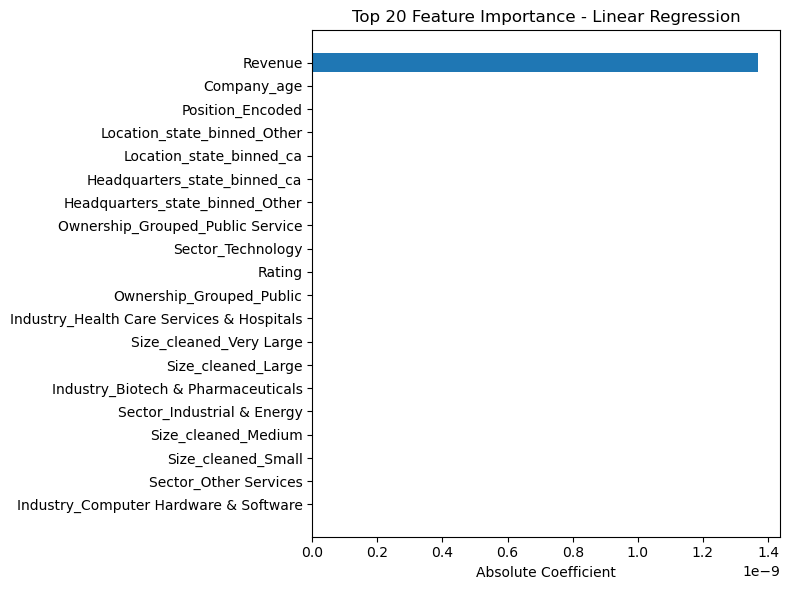

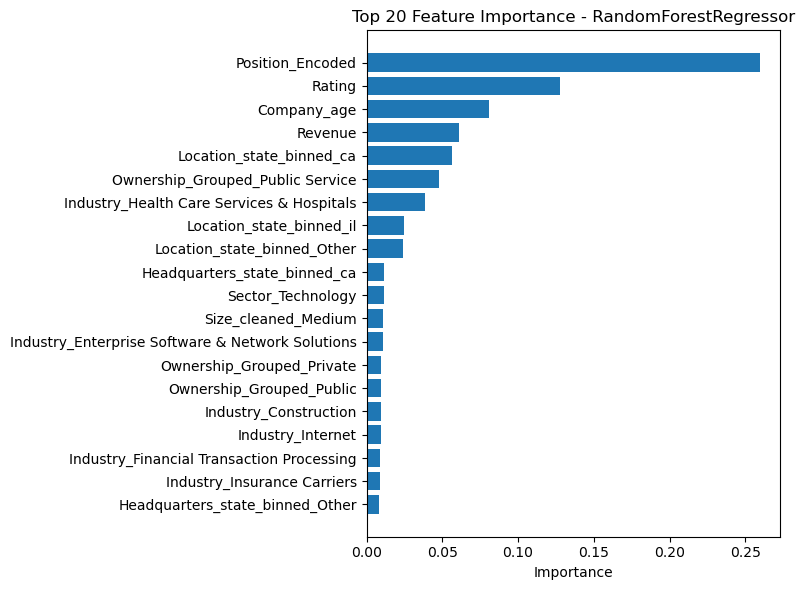

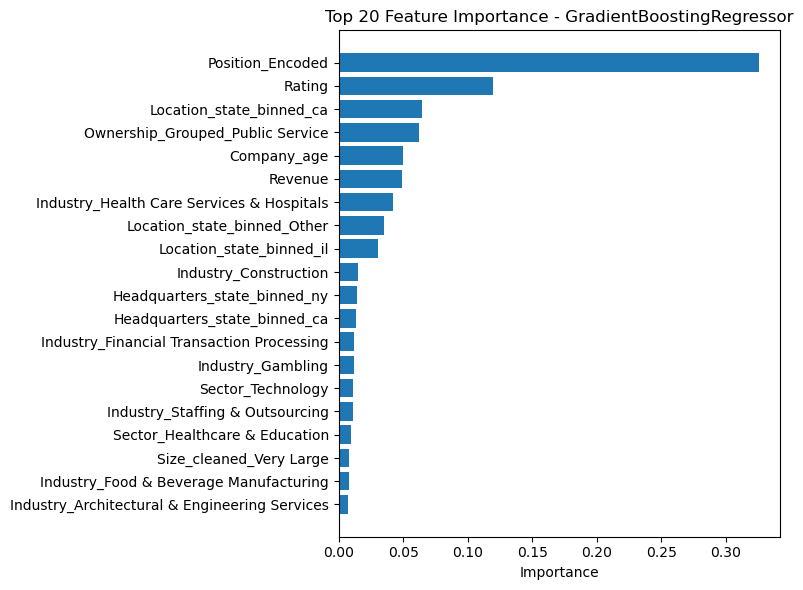

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.display import display

# ------------ 1. 데이터 로드 ------------
file_path = "glassdoor_cleaned_final.csv"
df = pd.read_csv(file_path)

# ------------ 2. 타깃 결측 행 제거 ------------
df_train = df[~df['avg_salary'].isna()].copy()
X_train = df_train[numeric_features + categorical_features]
y_train = df_train['avg_salary']

# ------------ 3. 컬럼 구분 ------------
numeric_features = [
    'Position_Encoded',
    'Rating',
    'Company_age',
    'Revenue'
]
categorical_features = [
    'Location_state_binned',
    'Headquarters_state_binned',
    'works_at_headquarters',
    'Size_cleaned',
    'Ownership_Grouped',
    'Industry',
    'Sector'
]

# ------------ 4. 공통 전처리 ------------
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# ------------ 5. 모델 파이프라인 ------------
lin_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    ))
])

gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# ------------ 6. 평가 함수 ------------
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)
scoring = {
    'R2':   'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE':  'neg_mean_absolute_error'
}

def evaluate(pipe):
    cv_results = cross_validate(pipe, X_train, y_train,
                                scoring=scoring, cv=cv, n_jobs=-1,
                                return_train_score=False)
    return {
        'R2_mean':   np.mean(cv_results['test_R2']),
        'RMSE_mean': -np.mean(cv_results['test_RMSE']),
        'MAE_mean':  -np.mean(cv_results['test_MAE'])
    }

lin_metrics = evaluate(lin_pipeline)
rf_metrics  = evaluate(rf_pipeline)
gbr_metrics = evaluate(gbr_pipeline)

results_df = pd.DataFrame([
    {'Model': 'Linear Regression',         **lin_metrics},
    {'Model': 'RandomForestRegressor',     **rf_metrics},
    {'Model': 'GradientBoostingRegressor', **gbr_metrics}
]).sort_values('R2_mean', ascending=False)

display(results_df.style.set_caption("Model Evaluation Metrics"))

# ------------ 7. 전체 학습 ------------
lin_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
gbr_pipeline.fit(X_train, y_train)

# ------------ 8. Feature Importance ------------
def get_feature_names(pipe):
    ohe = pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(categorical_features)
    return np.concatenate([numeric_features, cat_names])

# Linear
lin_importance = (pd.DataFrame({
    'Feature': get_feature_names(lin_pipeline),
    'Importance': np.abs(lin_pipeline.named_steps['regressor'].coef_)
}).sort_values('Importance', ascending=False).head(20))

# RandomForest
rf_importance = (pd.DataFrame({
    'Feature': get_feature_names(rf_pipeline),
    'Importance': rf_pipeline.named_steps['regressor'].feature_importances_
}).sort_values('Importance', ascending=False).head(20))

# GradientBoosting
gbr_importance = (pd.DataFrame({
    'Feature': get_feature_names(gbr_pipeline),
    'Importance': gbr_pipeline.named_steps['regressor'].feature_importances_
}).sort_values('Importance', ascending=False).head(20))

# 시각화
for title, imp in [
    ('Linear Regression', lin_importance),
    ('RandomForestRegressor', rf_importance),
    ('GradientBoostingRegressor', gbr_importance)
]:
    plt.figure(figsize=(8, 6))
    plt.barh(imp['Feature'], imp['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 Feature Importance - {title}')
    plt.xlabel('Importance' if 'Random' in title or 'Gradient' in title else 'Absolute Coefficient')
    plt.tight_layout()
    plt.show()

# ------------ 9. 최고 모델 선택 ------------
best_model_name = results_df.iloc[0]['Model']
pipeline_dict = {
    'Linear Regression':            lin_pipeline,
    'RandomForestRegressor':        rf_pipeline,
    'GradientBoostingRegressor':    gbr_pipeline
}
best_pipeline = pipeline_dict[best_model_name]

# ------------ 10. 결측 avg_salary 예측 및 채우기 ------------
df_missing = df[df['avg_salary'].isna()].copy()
if not df_missing.empty:
    X_missing = df_missing[numeric_features + categorical_features]
    y_pred_missing = best_pipeline.predict(X_missing)
    df.loc[df['avg_salary'].isna(), 'avg_salary'] = y_pred_missing

# ------------ 11. min/max 급여 컬럼 제거 & 열 순서 재배치 ------------
df_no_minmax = df.drop(columns=['min_salary', 'max_salary'], errors='ignore')

ordered_cols = [c for c in df_no_minmax.columns if c != 'avg_salary'] + ['avg_salary']
df_final = df_no_minmax[ordered_cols]

# ------------ 12. CSV 저장 ------------
output_path = "modeling.csv"
df_final.to_csv(output_path, index=False)


# 1. 모델 성능 해석 
먼저 *R²은 모델이 실제 급여의 변동성을 얼마나 설명하는지를 나타냅니다. 값이 1에 가까울수록 완벽한 설명력을, 0이면 단순 평균 수준에 불과함을, 0보다 작으면 평균만 예측하는 것보다도 못하다는 의미를 갖습니다. 이번 결과에서 RandomForest Regressor의 R²는 약 0.673으로, 전체 급여 변동의 약 67 %를 설명해 주었습니다. 반면 Gradient Boosting Regressor는 약 0.568로 57 % 정도를 설명했으며, Linear Regression은 –0.004로 0보다 작아서 평균으로만 예측하는 것보다도 성능이 낮았습니다. 이 값들만 보아도 선형 회귀가 데이터 구조를 거의 포착하지 못했고, 특히 RandomForest가 훨씬 효과적임을 알 수 있습니다.

다음으로 RMSE 는 제곱 오차의 평균에 루트를 씌운 값으로, 큰 오차에 특히 민감합니다. 숫자가 작을수록 예측이 실제 값에 가깝다는 뜻입니다. RandomForest의 RMSE는 약 21.6 로 가장 낮았고, Gradient Boosting은 약 24.9 , Linear Regression은 38.4 이었습니다. 따라서 RandomForest가 가장 예측력이 높으며 Gradient Boosting은 그보다 약간 덜, 선형 회귀는 훨씬 더 크게 빗나간다는 점이 드러납니다.

MAE는 오차의 절대값 평균으로, 평균적으로 얼마만큼 빗나갔는가를 직관적으로 알려 줍니다. 여기서도 RandomForest가 약 14.1 로 가장 낮아, 평균적으로 14 정도의 오차 범위 안에 예측이 머무른다는 의미입니다. Gradient Boosting은 약 18.7 , Linear Regression은 30  이상이어서 순위가 동일하게 유지됩니다.

정리하면, 세 가지 핵심 지표(R²는 높을수록 좋고, RMSE·MAE는 낮을수록 좋다는 기준)에 대해 RandomForest Regressor는 모두에서 가장 우수한 값을 기록했습니다. 이는 급여처럼 복잡한 비선형·상호작용 구조를 가진 타깃을 예측할 때, 트리 기반 앙상블이 단순 선형 회귀나 깊이가 제한된 Gradient Boosting보다 훨씬 효과적임을 보여 주는 객관적 근거가 됩니다.

# 2. Feature Importance 분석

1. Linear Regression 모델
Revenue (매출 규모)의 절댓값 계수가 압도적으로 크고, 나머지 특성들은 거의 0에 가깝다.

스케일 지배 현상
회귀식이 매출액의 단위(예: 억 원, 달러 단위)가 다른 변수보다 훨씬 커서 하나의 변수로만 설명하려고 함.
표준화나 로그 변환을 하지 않으면 선형 회귀가 특정 대규모 변수에만 의존한다는 고전적인 사례.

실제 급여 결정 요인 파악에 한계
Revenue 외 변수의 계수가 거의 0이므로 직무, 평판(Rating), 지역 등 인적 요인을 설명식에 충분히 반영하지 못했다.
이 때문에 모델 성능도 매우 낮았던 것으로 보인다.

개선 포인트
Revenue 로그 변환 + 수치형 스케일 표준화 후 다시 적합하면 다른 변수의 영향력이 드러날 가능성이 높다.
하지만 선형 가정 자체가 맞지 않을 수 있으므로 다른 모델과 함께 검증 필요.

2. RandomForest Regressor
Position이 급여를 가장 강하게 설명
동일 회사·지역이라도 개발, 컨설팅, 연구직 여부에 따라 급여 차이가 크다는 일반적 현상과 일치.

Rating 
평판이 좋은 회사일수록 급여 수준이나 복지로 경쟁력을 유지하려는 경향이 데이터에 반영된 가능성.

Company_age 
스타트업·신생 기업은 현금보다는 주식·옵션 비중이 높아 평균 급여가 낮을 수 있음.
반대로 오래된 대기업은 현금 급여가 안정화되어 높게 측정되는 패턴.

Revenue
매출이 크다고 반드시 평균 급여가 가장 높은 것은 아니며, 직무·평판·연차 요인이 더 직접적이라는 해석을 뒷받침.

Location_state_binned_ca (캘리포니아)
생활비·경쟁 구인 시장으로 인해 평균 급여가 상승하는 지역 효과.

3. Gradient Boosting Regressor

Position과 Rating이 다시 1·2위 → RandomForest 결과와 동일한 결과로 객관성 강화

지역 효과(캘리포니아)가 3위로 더 부각
동일 회사·지역이라도 개발, 컨설팅, 연구직 여부에 따라 급여 차이가 크다는 일반적 현상과 일치.

공공서비스 산업군 변수가 10위 안에 다수 포함
트리 기반 부스팅이 희소 더미 변수를 세밀하게 분할하면서 해당 요인의 상대적 중요도를 더 높게 평가하여 발생함으로 예상
